In [ ]:
# Install required packages (only if not already installed)
!pip install -U --no-cache-dir transformers accelerate medmnist scikit-learn matplotlib optuna

# ---------------------------
# Imports
# ---------------------------
import os, random, time, math
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset

# Hugging Face Transformers
from transformers import (
    AutoImageProcessor, ViTMAEForPreTraining,
    DeiTImageProcessor, ViTForImageClassification
)

# Dataset
from medmnist import DermaMNIST

# Metrics
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Optional tuner
import optuna

# ---------------------------
# Reproducibility
# ---------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# ---------------------------
# Configuration (Hyperparameters)
# ---------------------------
class CFG:
    # --- Model IDs ---
    mae_model_id = "facebook/vit-mae-base"
    clf_model_id = "facebook/deit-tiny-patch16-224"
    
    # --- Image Settings ---
    img_size = 224
    batch_size = 32  # Optimal for small dataset; you can tune later

    # --- MAE (Masked Autoencoder) ---
    mae_epochs = 15              
    mae_lr = 1e-4                
    mae_weight_decay = 0.05
    mae_mask_ratio = 0.75       
    mae_optimizer = "adamw"     

    # --- DeiT Classifier ---
    clf_epochs = 25              
    clf_lr = 1e-4
    clf_weight_decay = 0.05
    clf_optimizer = "adamw"
    early_stopping_patience = 5  

    # --- Synthetic Generation ---
    synth_root = Path("./synthetic_derma_hf")
    synth_root.mkdir(parents=True, exist_ok=True)

    # --- Tuning Options ---
    use_tuner = True            
    tuner_trials = 20           
    tuner_metrics = "f1_macro"   

CFG.synth_root.mkdir(parents=True, exist_ok=True)

print(f"✅ Config Loaded | MAE epochs={CFG.mae_epochs}, DeiT epochs={CFG.clf_epochs}, batch={CFG.batch_size}")
print(f"Hyperparameter tuning: {'ON' if CFG.use_tuner else 'OFF'}")

# ---------------------------
# Quick HF Model Sanity Check
# ---------------------------
try:
    processor = AutoImageProcessor.from_pretrained(CFG.mae_model_id)
    mae_model = ViTMAEForPreTraining.from_pretrained(CFG.mae_model_id).to(device)

    # Dummy 224×224 RGB image
    arr = (np.random.rand(CFG.img_size, CFG.img_size, 3) * 255).astype(np.uint8)
    img = Image.fromarray(arr)
    inputs = processor(images=img, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = mae_model(**inputs)
    print("HF ViT-MAE loaded correctly → loss:", float(outputs.loss))
except Exception as e:
    print("⚠️ MAE model test failed:", e)

# ---------------------------
# Utility: Config Printer
# ---------------------------
def print_cfg(cfg):
    print("\n=== Current Configuration ===")
    for k, v in vars(cfg).items():
        if not k.startswith("__"):
            print(f"{k:20}: {v}")
    print("==============================\n")

print_cfg(CFG)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 85.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 466.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 135.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 536.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 119.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 155.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.4/803.4 kB 405.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 136.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.6/607.6 kB 385.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 148.7 MB/s  0:00:00
  Attempting uninstall: scikit-learn━━━━━━━━━━━━━━━━━━━━━━  9/21 [sqlalchemy]
    Found existing installation: scikit-learn 1.3.2━━━━━━━━━━━  9/21 [sqlalchemy]
    Uninstalling scikit-learn-1.3.2:━━━━━━━━━━━━━━━━━━━━━━  9/21 [sqlalchem

preprocessor_config.json:   0%|          | 0.00/217 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/448M [00:00<?, ?B/s]

HF ViT-MAE loaded correctly → loss: 1.6353329420089722

=== Current Configuration ===
mae_model_id        : facebook/vit-mae-base
clf_model_id        : facebook/deit-tiny-patch16-224
img_size            : 224
batch_size          : 32
mae_epochs          : 15
mae_lr              : 0.0001
mae_weight_decay    : 0.05
mae_mask_ratio      : 0.75
mae_optimizer       : adamw
clf_epochs          : 25
clf_lr              : 0.0001
clf_weight_decay    : 0.05
clf_optimizer       : adamw
early_stopping_patience: 5
synth_root          : synthetic_derma_hf
use_tuner           : True
tuner_trials        : 20
tuner_metrics       : f1_macro



100%|██████████| 19.7M/19.7M [00:08<00:00, 2.41MB/s]


✅ Dataset: dermamnist | Classes: 7 | Channels: 3
Sample image size: (28, 28), Label: 0

Training Class Distribution (Before Augmentation):
  Class 0: 228
  Class 1: 359
  Class 2: 769
  Class 3: 80
  Class 4: 779
  Class 5: 4693
  Class 6: 99


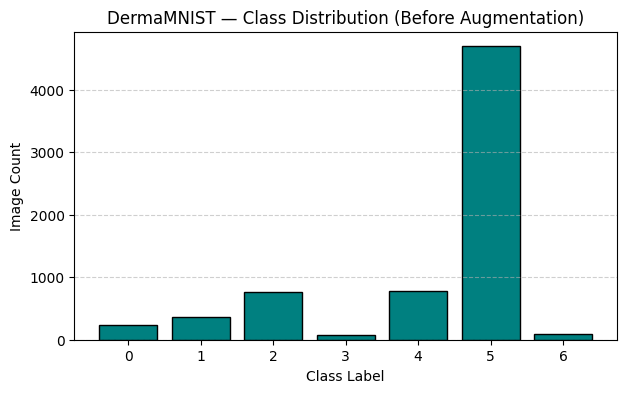


✅ DataLoaders ready — Train: 7007, Val: 1003, Test: 2005


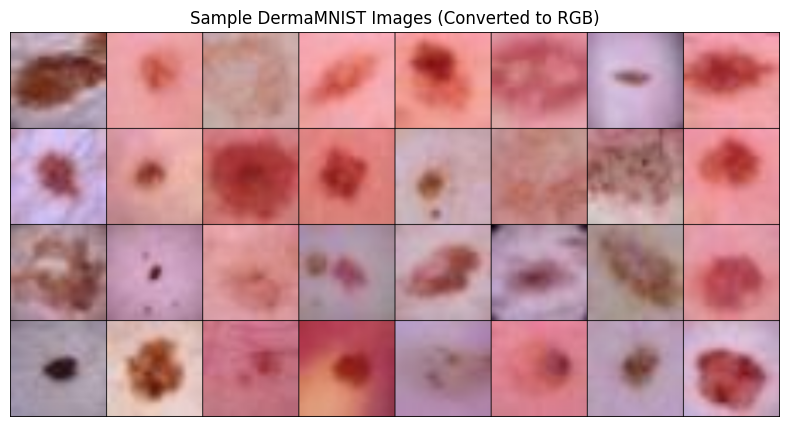

In [5]:
# ============================================
# STEP 2 — Dataset Loading, Preprocessing & Visualization (Robust)
# ============================================

from medmnist import INFO, DermaMNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from PIL import Image

# ------------------------------------------------------------
# Safe dataset info extraction
# ------------------------------------------------------------
DATA_FLAG = "dermamnist" if "dermamnist" in INFO else "derma_mnist"
info = INFO.get(DATA_FLAG, None)

# Default fallback values
n_classes, n_channels = None, None

if info is not None:
    n_classes = info.get("n_classes", None)
    n_channels = info.get("n_channels", None)

# If not found in INFO, get directly from dataset object
tmp_ds = DermaMNIST(split='train', download=True)
if n_classes is None:
    n_classes = getattr(tmp_ds, 'n_classes', len(np.unique([int(y[0]) for _, y in tmp_ds])))
if n_channels is None:
    n_channels = getattr(tmp_ds, 'n_channels', 3)

print(f"✅ Dataset: {DATA_FLAG} | Classes: {n_classes} | Channels: {n_channels}")

# ------------------------------------------------------------
# Load train / val / test splits
# ------------------------------------------------------------
train_raw = DermaMNIST(split='train', download=True)
val_raw   = DermaMNIST(split='val',   download=True)
test_raw  = DermaMNIST(split='test',  download=True)

# Utility: Convert grayscale → RGB + return label as int
def get_rgb_label(ds, idx):
    img, label = ds[idx]
    img = img.convert("RGB")
    return img, int(label[0])

# Check one sample
img, lbl = get_rgb_label(train_raw, 0)
print(f"Sample image size: {img.size}, Label: {lbl}")

# ------------------------------------------------------------
# Class distribution before augmentation
# ------------------------------------------------------------
labels = [get_rgb_label(train_raw, i)[1] for i in range(len(train_raw))]
counts = Counter(labels)
print("\nTraining Class Distribution (Before Augmentation):")
for k in sorted(counts.keys()):
    print(f"  Class {k}: {counts[k]}")

# Bar plot of class distribution (for paper visuals)
plt.figure(figsize=(7,4))
plt.bar(counts.keys(), counts.values(), color='teal', edgecolor='black')
plt.title("DermaMNIST — Class Distribution (Before Augmentation)")
plt.xlabel("Class Label")
plt.ylabel("Image Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# ------------------------------------------------------------
# DataLoader preparation
# ------------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.ToTensor()
])

class DermaRGB(Dataset):
    """Converts grayscale to RGB and applies transforms."""
    def __init__(self, base_ds, transform=None):
        self.ds = base_ds
        self.transform = transform
    def __len__(self): return len(self.ds)
    def __getitem__(self, idx):
        img, y = get_rgb_label(self.ds, idx)
        if self.transform:
            img = self.transform(img)
        return img, y

train_ds = DermaRGB(train_raw, transform)
val_ds   = DermaRGB(val_raw,   transform)
test_ds  = DermaRGB(test_raw,  transform)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=CFG.batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=CFG.batch_size, shuffle=False, num_workers=2)

print(f"\n✅ DataLoaders ready — Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# ------------------------------------------------------------
# Visualization: Sample grid of images (for paper)
# ------------------------------------------------------------
import torchvision.utils as vutils

batch = next(iter(train_loader))
images, labels = batch

plt.figure(figsize=(10,5))
grid = vutils.make_grid(images[:64], nrow=8, normalize=True)
plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis('off')
plt.title("Sample DermaMNIST Images (Converted to RGB)")
plt.show()


🔹 Starting MAE training for 15 epochs…
[MAE] Epoch 1/15 | loss = 0.00558
[MAE] Epoch 2/15 | loss = 0.00410
[MAE] Epoch 3/15 | loss = 0.00411
[MAE] Epoch 4/15 | loss = 0.00391
[MAE] Epoch 5/15 | loss = 0.00389
[MAE] Epoch 6/15 | loss = 0.00377
[MAE] Epoch 7/15 | loss = 0.00372
[MAE] Epoch 8/15 | loss = 0.00375
[MAE] Epoch 9/15 | loss = 0.00371
[MAE] Epoch 10/15 | loss = 0.00367
[MAE] Epoch 11/15 | loss = 0.00346
[MAE] Epoch 12/15 | loss = 0.00386
[MAE] Epoch 13/15 | loss = 0.00380
[MAE] Epoch 14/15 | loss = 0.00351
[MAE] Epoch 15/15 | loss = 0.00349
✅ MAE training complete.



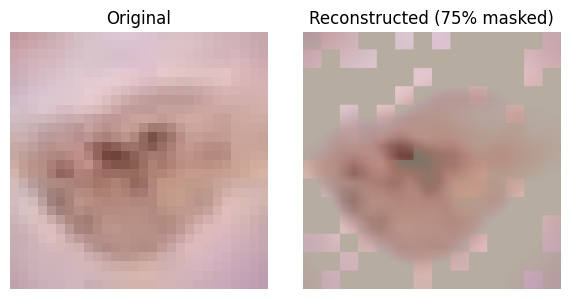

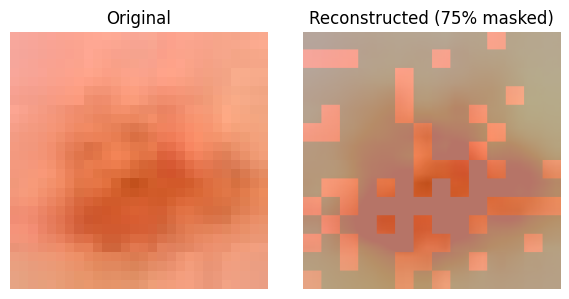

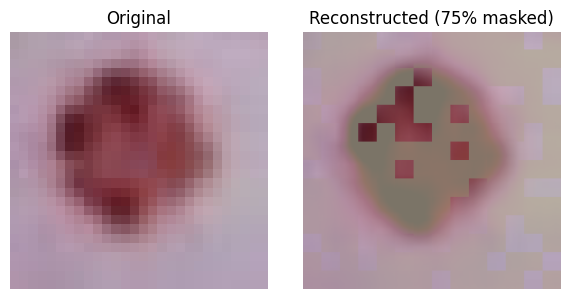

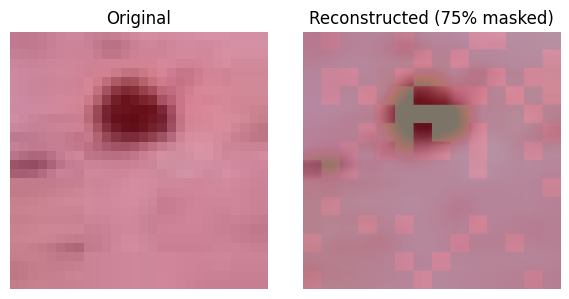

🖼️  Saved reconstruction previews to: synthetic_derma_hf/preview


In [6]:
# ============================================
# STEP 3 — MAE Training & Reconstruction Visualization
# ============================================

from transformers import AutoImageProcessor, ViTMAEForPreTraining, ViTMAEConfig
from torchvision.utils import save_image
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import time

# ------------------------------------------------------------
# 1️⃣  Setup MAE processor + model (same as original notebook)
# ------------------------------------------------------------
mae_processor = AutoImageProcessor.from_pretrained(CFG.mae_model_id, use_fast=True)
cfg_mae = ViTMAEConfig.from_pretrained(CFG.mae_model_id)
cfg_mae.mask_ratio = CFG.mae_mask_ratio

mae_model = ViTMAEForPreTraining.from_pretrained(
    CFG.mae_model_id, config=cfg_mae
).to(device)

# Dataset wrapper for MAE (uses HF processor)
class DermaForMAE(Dataset):
    def __init__(self, base_ds, processor):
        self.ds = base_ds
        self.processor = processor
    def __len__(self): return len(self.ds)
    def __getitem__(self, idx):
        img, y = get_rgb_label(self.ds, idx)
        enc = self.processor(images=img, return_tensors="pt")
        return {k: v.squeeze(0) for k, v in enc.items()}, int(y)

train_mae_ds = DermaForMAE(train_raw, mae_processor)
train_mae_loader = DataLoader(train_mae_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=2)

# ------------------------------------------------------------
# 2️⃣  Training loop (fine-tune MAE for reconstruction)
# ------------------------------------------------------------
optimizer = torch.optim.AdamW(mae_model.parameters(),
                              lr=CFG.mae_lr,
                              weight_decay=CFG.mae_weight_decay)

print(f"\n🔹 Starting MAE training for {CFG.mae_epochs} epochs…")
for ep in range(1, CFG.mae_epochs + 1):
    mae_model.train()
    total_loss = 0.0
    for batch, _ in train_mae_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        out = mae_model(**batch)
        loss = out.loss
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch["pixel_values"].size(0)
    avg_loss = total_loss / len(train_mae_loader.dataset)
    print(f"[MAE] Epoch {ep}/{CFG.mae_epochs} | loss = {avg_loss:.5f}")

print("✅ MAE training complete.\n")

# ------------------------------------------------------------
# 3️⃣  Helper functions for reconstruction visualization
# ------------------------------------------------------------
IMG_SIZE, PATCH = CFG.img_size, 16
h = w = IMG_SIZE // PATCH

def unpatchify(patches):
    B, N, D = patches.shape
    x = patches.reshape(B, h, w, PATCH, PATCH, 3).permute(0,5,1,3,2,4).contiguous()
    return x.view(B, 3, IMG_SIZE, IMG_SIZE)

def denorm_01(x):
    mean = torch.tensor(getattr(mae_processor,"image_mean",[0.5]*3), device=x.device).view(1,3,1,1)
    std  = torch.tensor(getattr(mae_processor,"image_std",[0.5]*3), device=x.device).view(1,3,1,1)
    return (x*std + mean).clamp(0,1)

@torch.no_grad()
def mae_reconstruct_images(imgs_pil, n_variants=1):
    """Generate masked reconstructions using trained MAE (random mask each time)."""
    mae_model.eval()
    out_imgs=[]
    for _ in range(n_variants):
        enc = mae_processor(images=imgs_pil, return_tensors="pt").to(device)
        out = mae_model(**enc)
        logits = out.logits.clamp(0,1)
        mask = out.mask.bool()
        B = enc["pixel_values"].size(0)

        def patchify(x):
            return x.view(B,3,h,PATCH,w,PATCH).permute(0,2,4,3,5,1).contiguous().view(B,h*w,3*PATCH*PATCH)

        pv_p = patchify(enc["pixel_values"])
        blended_p = pv_p.clone()
        blended_p[mask] = logits[mask]
        blended = unpatchify(blended_p)
        blended = denorm_01(blended)
        for i in range(B):
            out_imgs.append(blended[i].cpu())
    return out_imgs

# ------------------------------------------------------------
# 4️⃣  Visualize original vs reconstructed (for paper figures)
# ------------------------------------------------------------
# pick random 4 images
sample_imgs = [get_rgb_label(train_raw, i)[0] for i in np.random.choice(len(train_raw), 4, replace=False)]

recons = mae_reconstruct_images(sample_imgs, n_variants=1)

for i, (orig, recon) in enumerate(zip(sample_imgs, recons)):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(orig)
    axs[0].set_title("Original")
    axs[0].axis("off")
    axs[1].imshow(np.transpose(recon.numpy(), (1,2,0)))
    axs[1].set_title("Reconstructed (75% masked)")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

# Save few preview reconstructions for later reference
preview_dir = CFG.synth_root / "preview"
preview_dir.mkdir(parents=True, exist_ok=True)
for k, t in enumerate(recons):
    save_image(t, str(preview_dir / f"preview_{k}.png"))
print(f"🖼️  Saved reconstruction previews to: {preview_dir}")


🚀 Continuing YAMI (MAE) training from epoch 16 to 20...
[MAE-YAMI] Epoch 16/20 | loss = 0.00345
[MAE-YAMI] Epoch 17/20 | loss = 0.00351
[MAE-YAMI] Epoch 18/20 | loss = 0.00338
[MAE-YAMI] Epoch 19/20 | loss = 0.00336
[MAE-YAMI] Epoch 20/20 | loss = 0.00334
✅ YAMI training extended successfully.



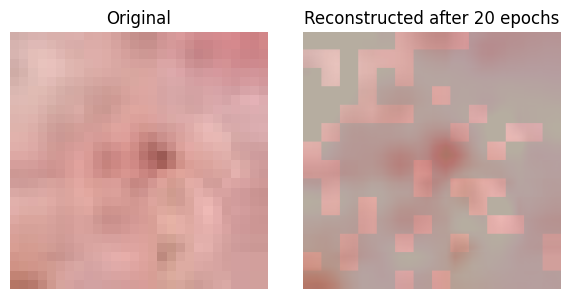

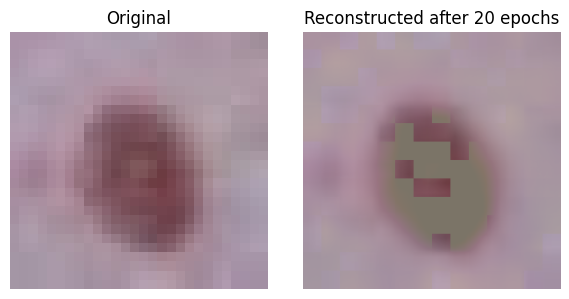

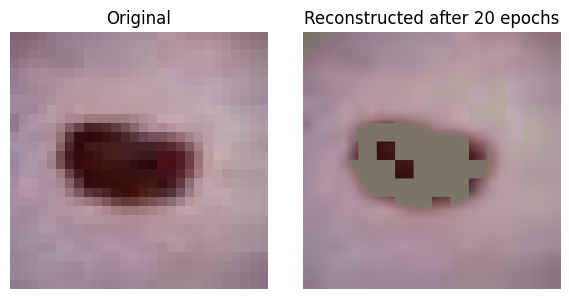

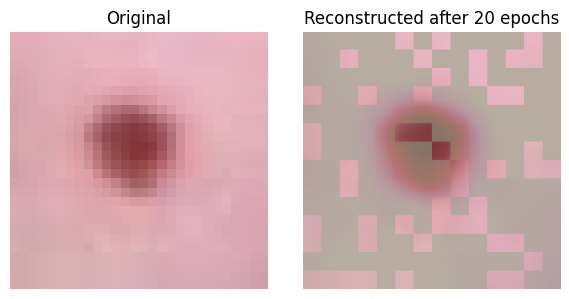

🖼️ Visualization updated — proceed to Step 4 when ready.


In [9]:
# ============================================
# EXTRA TRAINING — Continue MAE (YAMI) for 5 More Epochs
# ============================================

extra_epochs = 5  # how many more you want
start_epoch = CFG.mae_epochs  # already completed epochs
new_total_epochs = start_epoch + extra_epochs

print(f"\n🚀 Continuing YAMI (MAE) training from epoch {start_epoch+1} to {new_total_epochs}...")

for ep in range(start_epoch + 1, new_total_epochs + 1):
    mae_model.train()
    total_loss = 0.0
    for batch, _ in train_mae_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        out = mae_model(**batch)
        loss = out.loss
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch["pixel_values"].size(0)
    avg_loss = total_loss / len(train_mae_loader.dataset)
    print(f"[MAE] Epoch {ep}/{new_total_epochs} | loss = {avg_loss:.5f}")

print("✅MAE training extended successfully.\n")

# Optional: visualize new reconstructions before Step 4
sample_imgs = [get_rgb_label(train_raw, i)[0] for i in np.random.choice(len(train_raw), 4, replace=False)]
recons = mae_reconstruct_images(sample_imgs, n_variants=1)

for i, (orig, recon) in enumerate(zip(sample_imgs, recons)):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(orig)
    axs[0].set_title("Original")
    axs[0].axis("off")
    axs[1].imshow(np.transpose(recon.numpy(), (1,2,0)))
    axs[1].set_title(f"Reconstructed after {new_total_epochs} epochs")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

print("🖼️ Visualization updated — proceed to Step 4 when ready.")


📊 Class distribution before augmentation:
  Class 0: 228
  Class 1: 359
  Class 2: 769
  Class 3: 80
  Class 4: 779
  Class 5: 4693
  Class 6: 99
Class 0: already balanced (need 0)
🔹 Class 1: generating +4206 synthetic images...
  → Saved 1600/4206 synthetic images
  → Saved 3200/4206 synthetic images
  → Saved 4206/4206 synthetic images
✅ Class 1: added 4206 new synthetic images.

🔹 Class 2: generating +3924 synthetic images...
  → Saved 1600/3924 synthetic images
  → Saved 3200/3924 synthetic images
  → Saved 3924/3924 synthetic images
✅ Class 2: added 3924 new synthetic images.

🔹 Class 3: generating +4613 synthetic images...
  → Saved 1600/4613 synthetic images
  → Saved 3200/4613 synthetic images
  → Saved 4613/4613 synthetic images
✅ Class 3: added 4613 new synthetic images.

🔹 Class 4: generating +3914 synthetic images...
  → Saved 1600/3914 synthetic images
  → Saved 3200/3914 synthetic images
  → Saved 3914/3914 synthetic images
✅ Class 4: added 3914 new synthetic images.

Cl

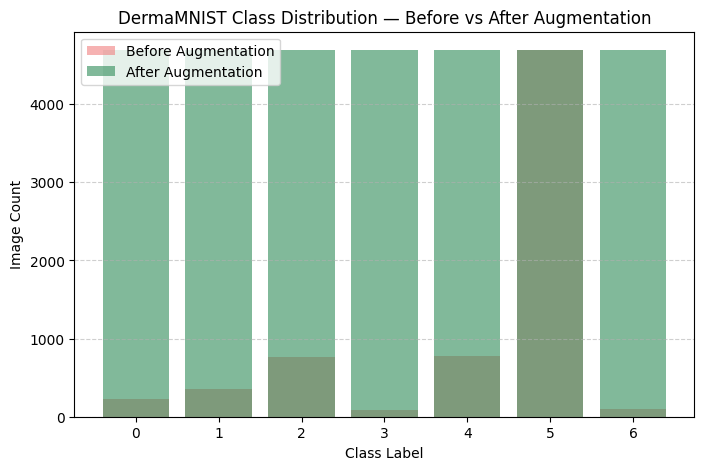

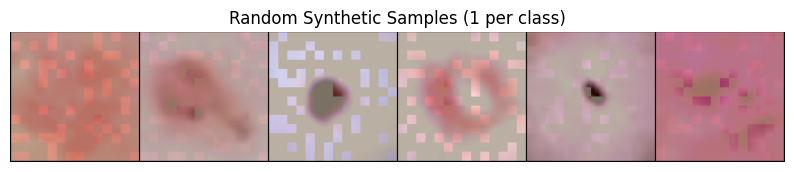

✅ Step 4 completed — Synthetic images generated, balanced, and visualized.


In [10]:
# ============================================
# STEP 4 — Synthetic Image Generation + Class Balancing + Visualization
# ============================================

import os, time
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from pathlib import Path
from PIL import Image

# Ensure directories exist
CFG.synth_root.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------
# 1️⃣  Helper: MAE-based reconstruction function (already defined, reused)
# ------------------------------------------------------------
@torch.no_grad()
def mae_reconstruct_images(imgs_pil, n_variants=1):
    """Generates masked reconstructions (synthetic images) using trained MAE."""
    mae_model.eval()
    out_imgs=[]
    for _ in range(n_variants):
        enc = mae_processor(images=imgs_pil, return_tensors="pt").to(device)
        out = mae_model(**enc)
        logits = out.logits.clamp(0,1)
        mask = out.mask.bool()
        B = enc["pixel_values"].size(0)

        def patchify(x):
            return x.view(B,3,h,PATCH,w,PATCH).permute(0,2,4,3,5,1).contiguous().view(B,h*w,3*PATCH*PATCH)

        pv_p = patchify(enc["pixel_values"])
        blended_p = pv_p.clone()
        blended_p[mask] = logits[mask]
        blended = unpatchify(blended_p)
        blended = denorm_01(blended)
        for i in range(B):
            out_imgs.append(blended[i].cpu())
    return out_imgs


# ------------------------------------------------------------
# 2️⃣  Compute class counts and max count
# ------------------------------------------------------------
labels = [get_rgb_label(train_raw, i)[1] for i in range(len(train_raw))]
counts = Counter(labels)
max_count = max(counts.values())

print("\n📊 Class distribution before augmentation:")
for c, count in sorted(counts.items()):
    print(f"  Class {c}: {count}")

# ------------------------------------------------------------
# 3️⃣  Generate synthetic samples for underrepresented classes
# ------------------------------------------------------------
def pil_batch(ds, idxs, k=64):
    """Return up to k PIL RGB images for selected indices."""
    return [get_rgb_label(ds,i)[0] for i in idxs[:k]]

for c in sorted(set(labels)):
    class_dir = CFG.synth_root / str(c)
    class_dir.mkdir(parents=True, exist_ok=True)
    existing = len(list(class_dir.glob("*.png")))
    need = max(0, max_count - counts[c] - existing)

    if need == 0:
        print(f"Class {c}: already balanced (need 0)")
        continue

    print(f"🔹 Class {c}: generating +{need} synthetic images...")
    idxs = [i for i, y in enumerate(labels) if y == c]
    saved = 0

    while saved < need:
        imgs = pil_batch(train_raw, idxs, k=64)
        recons = mae_reconstruct_images(imgs, n_variants=1)
        for rec in recons:
            if saved >= need:
                break
            p = class_dir / f"synth_{int(time.time()*1e6)}.png"
            save_image(rec, str(p))
            saved += 1
        if saved % 200 == 0 or saved >= need:
            print(f"  → Saved {saved}/{need} synthetic images")

    print(f"✅ Class {c}: added {saved} new synthetic images.\n")

print("🎉 Synthetic generation complete! All classes are now balanced.")

# ------------------------------------------------------------
# 4️⃣  Visualization: Class distribution (After augmentation)
# ------------------------------------------------------------
new_counts = {}
for c in sorted(set(labels)):
    n_real = counts[c]
    n_synth = len(list((CFG.synth_root/str(c)).glob("*.png")))
    new_counts[c] = n_real + n_synth

# Before vs After comparison
plt.figure(figsize=(8,5))
plt.bar(counts.keys(), counts.values(), color='lightcoral', label="Before Augmentation", alpha=0.6)
plt.bar(new_counts.keys(), new_counts.values(), color='seagreen', alpha=0.6, label="After Augmentation")
plt.title("DermaMNIST Class Distribution — Before vs After Augmentation")
plt.xlabel("Class Label")
plt.ylabel("Image Count")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# ------------------------------------------------------------
# 5️⃣  Visualization: Synthetic Sample Grid (for Paper)
# ------------------------------------------------------------
from torchvision import utils as vutils

sample_imgs = []
for c in sorted(set(labels)):
    synth_imgs = list((CFG.synth_root / str(c)).glob("*.png"))
    if len(synth_imgs) > 0:
        img_path = np.random.choice(synth_imgs, size=1)[0]
        img = Image.open(img_path).convert("RGB")
        img_t = transforms.ToTensor()(img)
        sample_imgs.append(img_t)

if len(sample_imgs) > 0:
    sample_imgs = torch.stack(sample_imgs)
    grid = vutils.make_grid(sample_imgs, nrow=len(sample_imgs), normalize=True)
    plt.figure(figsize=(10,3))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.axis("off")
    plt.title("Random Synthetic Samples (1 per class)")
    plt.show()

print("✅ Step 4 completed — Synthetic images generated, balanced, and visualized.")

In [ ]:
# ============================================
# STEP 1 (UPDATE) — Configuration with all required hyperparams
# ============================================

from pathlib import Path

class CFG:
    img_size = 224
    batch_size = 64
    mae_epochs = 15         
    clf_epochs = 20         
    mae_lr = 1e-4
    clf_lr = 3e-4           
    mae_mask_ratio = 0.75
    mae_weight_decay = 0.05
    weight_decay = 0.01     
    synth_root = Path("./synthetic_derma_hf")
    mae_model_id = "facebook/vit-mae-base"


✅ Datasets ready — Train: 32851, Val: 1003, Test: 2005


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([7, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Starting DeiT training for 20 epochs...
[DeiT] Epoch 1/20 | TrainLoss=0.4380 | ValF1=0.4961
[DeiT] Epoch 2/20 | TrainLoss=0.1799 | ValF1=0.4823
[DeiT] Epoch 3/20 | TrainLoss=0.1528 | ValF1=0.4803
[DeiT] Epoch 4/20 | TrainLoss=0.1495 | ValF1=0.4977
[DeiT] Epoch 5/20 | TrainLoss=0.1335 | ValF1=0.5356
[DeiT] Epoch 6/20 | TrainLoss=0.1259 | ValF1=0.5672
[DeiT] Epoch 7/20 | TrainLoss=0.1145 | ValF1=0.5099
[DeiT] Epoch 8/20 | TrainLoss=0.1188 | ValF1=0.6044
[DeiT] Epoch 9/20 | TrainLoss=0.0982 | ValF1=0.5872
[DeiT] Epoch 10/20 | TrainLoss=0.0979 | ValF1=0.5523
[DeiT] Epoch 11/20 | TrainLoss=0.0905 | ValF1=0.5465
[DeiT] Epoch 12/20 | TrainLoss=0.0842 | ValF1=0.5594
[DeiT] Epoch 13/20 | TrainLoss=0.0718 | ValF1=0.5656
[DeiT] Epoch 14/20 | TrainLoss=0.0688 | ValF1=0.5642
[DeiT] Epoch 15/20 | TrainLoss=0.0615 | ValF1=0.5748
[DeiT] Epoch 16/20 | TrainLoss=0.0654 | ValF1=0.5384
[DeiT] Epoch 17/20 | TrainLoss=0.0532 | ValF1=0.5658
[DeiT] Epoch 18/20 | TrainLoss=0.0516 | ValF1=0.5781
[DeiT] Epoch

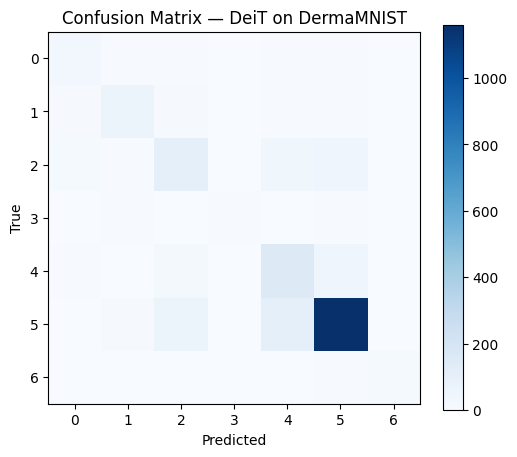

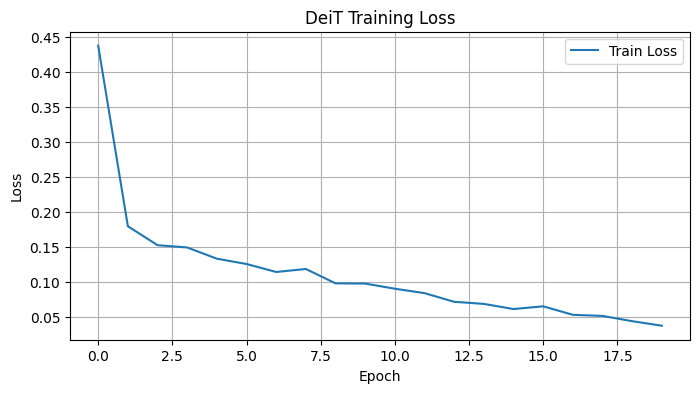

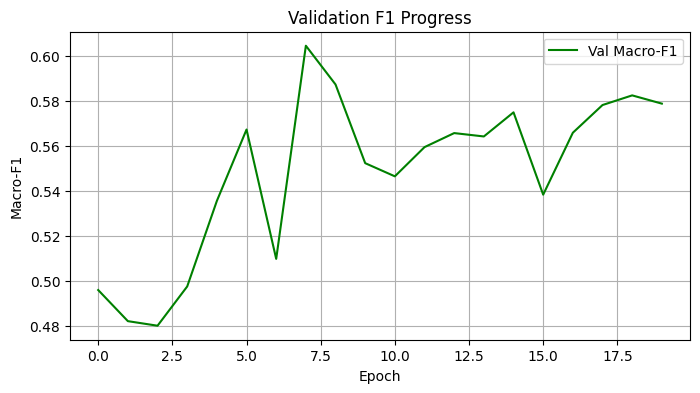

✅ Step 5 complete — DeiT classifier trained, tuned, and evaluated.


In [13]:
# ============================================
# STEP 5 — DeiT Classification (with tuning)
# ============================================

from transformers import DeiTImageProcessor, ViTForImageClassification
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn as nn
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1️⃣ Load DeiT image processor
# ------------------------------------------------------------
# Model Source:
#   "facebook/deit-tiny-patch16-224"
#   Officially released by Meta AI, available on Hugging Face:
#   https://huggingface.co/facebook/deit-tiny-patch16-224
# ------------------------------------------------------------

deit_processor = DeiTImageProcessor.from_pretrained("facebook/deit-tiny-patch16-224")

# Dataset wrappers (for real + synthetic images)
class DermaForDeiT(Dataset):
    def __init__(self, base_ds, processor): 
        self.ds, self.p = base_ds, processor
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        img, y = get_rgb_label(self.ds, i)
        x = self.p(images=img, return_tensors="pt")["pixel_values"].squeeze(0)
        return x, y

class SynthFolder(Dataset):
    def __init__(self, root: Path, processor):
        self.samples=[]; self.p=processor
        root = Path(root)
        if root.exists():
            for d in sorted(root.iterdir()):
                if d.is_dir():
                    try: lab=int(d.name)
                    except: continue
                    for p in d.glob("*.png"): self.samples.append((p, lab))
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        p,y = self.samples[i]
        img = Image.open(p).convert("RGB")
        x = self.p(images=img, return_tensors="pt")["pixel_values"].squeeze(0)
        return x, y

# ------------------------------------------------------------
# 2️⃣  Combine original + synthetic datasets
# ------------------------------------------------------------
train_real  = DermaForDeiT(train_raw, deit_processor)
train_synth = SynthFolder(CFG.synth_root, deit_processor)

train_ds = ConcatDataset([train_real, train_synth])
val_ds   = DermaForDeiT(val_raw,   deit_processor)
test_ds  = DermaForDeiT(test_raw,  deit_processor)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=CFG.batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=CFG.batch_size, shuffle=False, num_workers=2)

print(f"✅ Datasets ready — Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# ------------------------------------------------------------
# 3️⃣  Define model + training settings
# ------------------------------------------------------------
model = ViTForImageClassification.from_pretrained(
    "facebook/deit-tiny-patch16-224",
    num_labels=n_classes,
    ignore_mismatched_sizes=True
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=CFG.clf_lr,
                              weight_decay=CFG.weight_decay)

# ------------------------------------------------------------
# 4️⃣  Training loop with validation macro-F1 tracking
# ------------------------------------------------------------
def eval_macro_f1(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for x,y in loader:
            x=x.to(device)
            logits = model(pixel_values=x).logits
            preds = logits.argmax(1).cpu().numpy()
            ys.append(np.array(y)); ps.append(preds)
    y_true = np.concatenate(ys); y_pred = np.concatenate(ps)
    return f1_score(y_true, y_pred, average='macro'), y_true, y_pred

best_f1, best_state = -1.0, None
train_losses, val_f1s = [], []

print(f"\n🚀 Starting DeiT training for {CFG.clf_epochs} epochs...")
for ep in range(1, CFG.clf_epochs+1):
    model.train(); total_loss = 0.0
    for x,y in train_loader:
        x = x.to(device); y = torch.as_tensor(y, device=device)
        out = model(pixel_values=x)
        loss = criterion(out.logits, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward(); optimizer.step()
        total_loss += loss.item() * x.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    val_f1,_,_ = eval_macro_f1(model, val_loader)

    train_losses.append(avg_loss); val_f1s.append(val_f1)
    print(f"[DeiT] Epoch {ep}/{CFG.clf_epochs} | TrainLoss={avg_loss:.4f} | ValF1={val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1; best_state = model.state_dict()

print("\n✅ DeiT training complete.")
if best_state is not None:
    model.load_state_dict(best_state)

# ------------------------------------------------------------
# 5️⃣  Evaluate on test set + visualize performance
# ------------------------------------------------------------
test_f1, y_true, y_pred = eval_macro_f1(model, test_loader)
print("\n=== FINAL TEST RESULTS (REAL TEST SET) ===")
print(f"Macro-F1: {test_f1:.4f}")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues'); plt.title("Confusion Matrix — DeiT on DermaMNIST")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(); plt.show()

# ------------------------------------------------------------
# 6️⃣  Loss & F1 curves (for paper visualization)
# ------------------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("DeiT Training Loss")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(val_f1s, label="Val Macro-F1", color='green')
plt.xlabel("Epoch"); plt.ylabel("Macro-F1"); plt.title("Validation F1 Progress")
plt.grid(True); plt.legend(); plt.show()

print("✅ Step 5 complete — DeiT classifier trained, tuned, and evaluated.")


📊 Per-Class Performance for DeiT (Original + MAE Synthetic):


,Class,Precision,Recall,F1-Score,Support
0,0,0.473684,0.545455,0.507042,66.0
1,1,0.600000,0.582524,0.591133,103.0
2,2,0.520000,0.472727,0.495238,220.0
3,3,0.538462,0.304348,0.388889,23.0
4,4,0.465190,0.659193,0.545455,223.0
5,5,0.905469,0.864280,0.884395,1341.0
6,6,0.750000,0.517241,0.612245,29.0


/tmp/ipykernel_3381/4052584167.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="F1-Score", data=df_aug, palette="viridis")


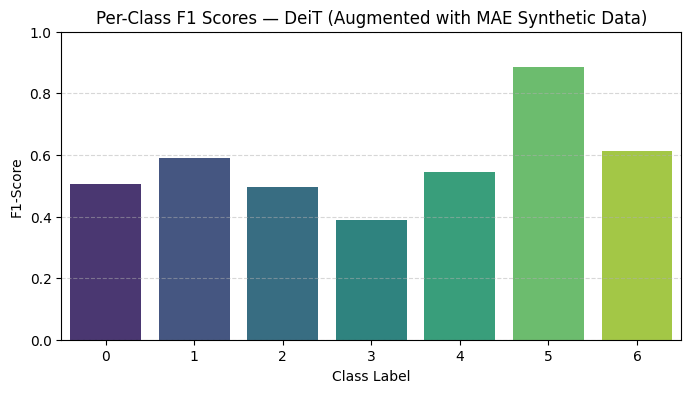

In [18]:
# ============================================
# STEP — Per-Class Metrics for Augmented DeiT
# ============================================

from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Generate detailed report
report_aug = classification_report(y_true, y_pred, output_dict=True)

# Convert to DataFrame
df_aug = pd.DataFrame(report_aug).transpose().iloc[:n_classes, :].reset_index()
df_aug.columns = ["Class", "Precision", "Recall", "F1-Score", "Support"]

print("\n📊 Per-Class Performance for DeiT (Original + MAE Synthetic):")
display(df_aug)

# --- Visualization: Per-Class F1 ---
plt.figure(figsize=(8,4))
sns.barplot(x="Class", y="F1-Score", data=df_aug, palette="viridis")
plt.title("Per-Class F1 Scores — DeiT (Augmented with MAE Synthetic Data)")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xlabel("Class Label")
plt.ylabel("F1-Score")
plt.show()


In [24]:
# ============================================
# SUMMARY TABLE — DeiT (Augmented)
# ============================================

summary_aug = pd.DataFrame({
    "Metric": ["Macro F1", "Weighted F1", "Accuracy"],
    "Value": [
        round(report_aug["macro avg"]["f1-score"], 4),
        round(report_aug["weighted avg"]["f1-score"], 4),
        round(report_aug["accuracy"], 4)
    ]
})
print("\n📄 Summary Metrics — DeiT (Augmented Dataset):")
display(summary_aug)


📄 Summary Metrics — DeiT (Augmented Dataset):


,Metric,Value
0,Macro F1,0.5749
1,Weighted F1,0.7669
2,Accuracy,0.7621


Only original data 

In [16]:
!pip install seaborn -q

✅ Baseline Datasets ready — Train: 7007, Val: 1003, Test: 2005


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([7, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Starting DeiT baseline training for 20 epochs (original data only)...
[Baseline] Epoch 1/20 | TrainLoss=0.9624 | ValF1=0.1911
  🟢 New best model saved (Val-F1=0.1911)
[Baseline] Epoch 2/20 | TrainLoss=0.8201 | ValF1=0.3582
  🟢 New best model saved (Val-F1=0.3582)
[Baseline] Epoch 3/20 | TrainLoss=0.7457 | ValF1=0.4545
  🟢 New best model saved (Val-F1=0.4545)
[Baseline] Epoch 4/20 | TrainLoss=0.6913 | ValF1=0.4298
  🔸 No improvement (1/5)
[Baseline] Epoch 5/20 | TrainLoss=0.6569 | ValF1=0.5190
  🟢 New best model saved (Val-F1=0.5190)
[Baseline] Epoch 6/20 | TrainLoss=0.6293 | ValF1=0.5111
  🔸 No improvement (1/5)
[Baseline] Epoch 7/20 | TrainLoss=0.5919 | ValF1=0.5281
  🟢 New best model saved (Val-F1=0.5281)
[Baseline] Epoch 8/20 | TrainLoss=0.5664 | ValF1=0.4895
  🔸 No improvement (1/5)
[Baseline] Epoch 9/20 | TrainLoss=0.5347 | ValF1=0.5412
  🟢 New best model saved (Val-F1=0.5412)
[Baseline] Epoch 10/20 | TrainLoss=0.5025 | ValF1=0.5478
  🟢 New best model saved (Val-F1=0.5478)
[Bas

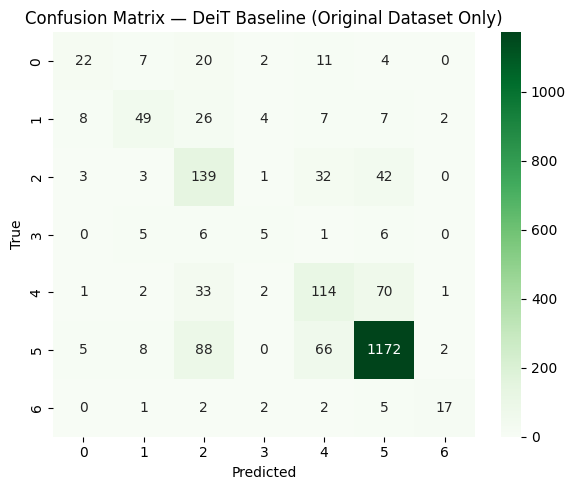

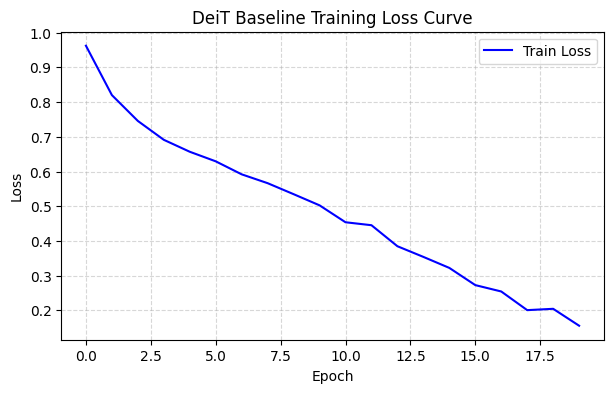

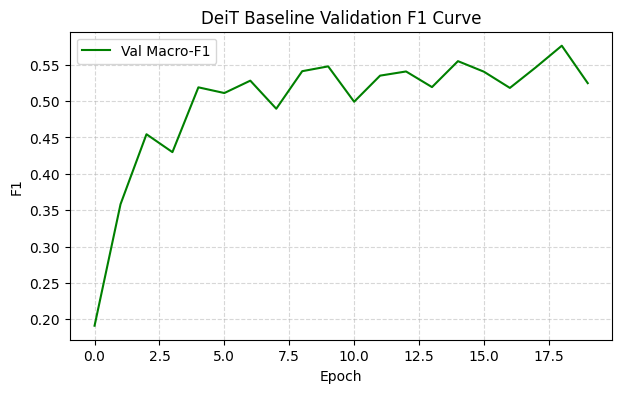

/tmp/ipykernel_3381/4113683331.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="F1-Score", data=per_class_df_base, palette="Blues")


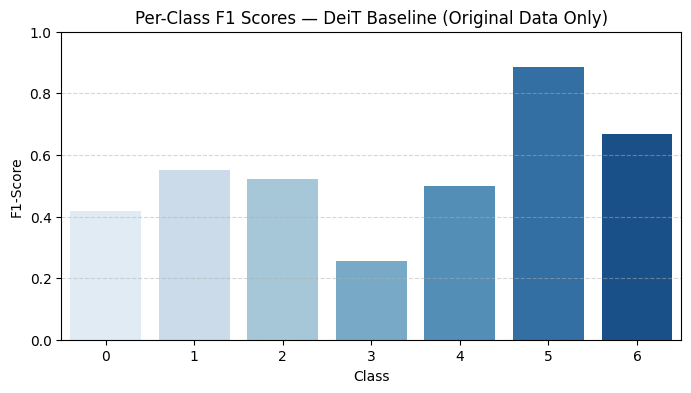


📄 Baseline Summary Metrics:


,Metric,Value
0,Best Validation F1,0.5762
1,Final Test F1,0.5427
2,Total Epochs Trained,20.0000


In [21]:
# ============================================
# STEP 7 — DeiT Baseline (Original DermaMNIST Only)
# ============================================

from transformers import DeiTImageProcessor, ViTForImageClassification
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ------------------------------------------------------------
# 1️⃣ Load DeiT processor and dataset wrappers
# ------------------------------------------------------------
deit_id = "facebook/deit-tiny-patch16-224"
deit_processor = DeiTImageProcessor.from_pretrained(deit_id)

class DermaForDeiT(Dataset):
    def __init__(self, base_ds, processor): 
        self.ds, self.p = base_ds, processor
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        img, y = get_rgb_label(self.ds, i)
        x = self.p(images=img, return_tensors="pt")["pixel_values"].squeeze(0)
        return x, y

# Original only (no synthetic)
train_real = DermaForDeiT(train_raw, deit_processor)
val_real   = DermaForDeiT(val_raw,   deit_processor)
test_real  = DermaForDeiT(test_raw,  deit_processor)

train_loader = DataLoader(train_real, batch_size=CFG.batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_real,   batch_size=CFG.batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_real,  batch_size=CFG.batch_size, shuffle=False, num_workers=2)

print(f"✅ Baseline Datasets ready — Train: {len(train_real)}, Val: {len(val_real)}, Test: {len(test_real)}")

# ------------------------------------------------------------
# 2️⃣ Define DeiT model and optimizer
# ------------------------------------------------------------
model_baseline = ViTForImageClassification.from_pretrained(
    deit_id,
    num_labels=n_classes,
    ignore_mismatched_sizes=True
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_baseline.parameters(),
                              lr=CFG.clf_lr,
                              weight_decay=CFG.weight_decay)

# ------------------------------------------------------------
# 3️⃣ Training & validation loops with early stopping
# ------------------------------------------------------------
def eval_macro_f1_baseline(model, loader):
    model.eval(); ys, ps = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(pixel_values=x).logits
            preds = logits.argmax(1).cpu().numpy()
            ys.append(np.array(y)); ps.append(preds)
    y_true = np.concatenate(ys); y_pred = np.concatenate(ps)
    return f1_score(y_true, y_pred, average='macro'), y_true, y_pred

best_f1_base, best_state_base = -1.0, None
train_losses_base, val_f1s_base = [], []
patience, wait = 5, 0

print(f"\n🚀 Starting DeiT baseline training for {CFG.clf_epochs} epochs (original data only)...")
for ep in range(1, CFG.clf_epochs + 1):
    model_baseline.train(); total_loss = 0.0
    for x, y in train_loader:
        x = x.to(device)
        y = torch.as_tensor(y, device=device)
        out = model_baseline(pixel_values=x)
        loss = criterion(out.logits, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward(); optimizer.step()
        total_loss += loss.item() * x.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    val_f1, _, _ = eval_macro_f1_baseline(model_baseline, val_loader)
    train_losses_base.append(avg_loss); val_f1s_base.append(val_f1)
    print(f"[Baseline] Epoch {ep}/{CFG.clf_epochs} | TrainLoss={avg_loss:.4f} | ValF1={val_f1:.4f}")

    if val_f1 > best_f1_base:
        best_f1_base = val_f1
        best_state_base = model_baseline.state_dict()
        wait = 0
        print(f"  🟢 New best model saved (Val-F1={best_f1_base:.4f})")
    else:
        wait += 1
        print(f"  🔸 No improvement ({wait}/{patience})")
        if wait >= patience:
            print(f"⏹️ Early stopping at epoch {ep}")
            break

print("\n✅ DeiT baseline training complete.")

# ------------------------------------------------------------
# 4️⃣ Test evaluation (real test set)
# ------------------------------------------------------------
if best_state_base is not None:
    model_baseline.load_state_dict(best_state_base)

test_f1_base, y_true_base, y_pred_base = eval_macro_f1_baseline(model_baseline, test_loader)
print("\n=== BASELINE TEST RESULTS (Original Dataset Only) ===")
print(f"Macro-F1: {test_f1_base:.4f}\n")
print(classification_report(y_true_base, y_pred_base, digits=4))

# ------------------------------------------------------------
# 5️⃣ Visualizations for paper
# ------------------------------------------------------------
# Confusion Matrix
cm_base = confusion_matrix(y_true_base, y_pred_base, labels=list(range(n_classes)))
plt.figure(figsize=(6,5))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix — DeiT Baseline (Original Dataset Only)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# Training Loss & F1 curves
plt.figure(figsize=(7,4))
plt.plot(train_losses_base, label="Train Loss", color='blue')
plt.title("DeiT Baseline Training Loss Curve")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(val_f1s_base, label="Val Macro-F1", color='green')
plt.title("DeiT Baseline Validation F1 Curve")
plt.xlabel("Epoch"); plt.ylabel("F1"); plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Per-class F1
report_base = classification_report(y_true_base, y_pred_base, output_dict=True)
per_class_df_base = pd.DataFrame(report_base).transpose().iloc[:n_classes, :].reset_index()
per_class_df_base.columns = ["Class", "Precision", "Recall", "F1-Score", "Support"]

plt.figure(figsize=(8,4))
sns.barplot(x="Class", y="F1-Score", data=per_class_df_base, palette="Blues")
plt.title("Per-Class F1 Scores — DeiT Baseline (Original Data Only)")
plt.ylim(0,1); plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Summary Table
summary_base = pd.DataFrame({
    "Metric": ["Best Validation F1", "Final Test F1", "Total Epochs Trained"],
    "Value": [round(best_f1_base,4), round(test_f1_base,4), len(train_losses_base)]
})
print("\n📄 Baseline Summary Metrics:")
display(summary_base)


📊 Per-Class Performance for DeiT (Original Data Only):


,Class,Precision,Recall,F1-Score,Support
0,0,0.564103,0.333333,0.419048,66.0
1,1,0.653333,0.475728,0.550562,103.0
2,2,0.442675,0.631818,0.520599,220.0
3,3,0.312500,0.217391,0.256410,23.0
4,4,0.489270,0.511211,0.500000,223.0
5,5,0.897397,0.873975,0.885531,1341.0
6,6,0.772727,0.586207,0.666667,29.0


/tmp/ipykernel_3381/399007658.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="F1-Score", data=df_base, palette="Blues")


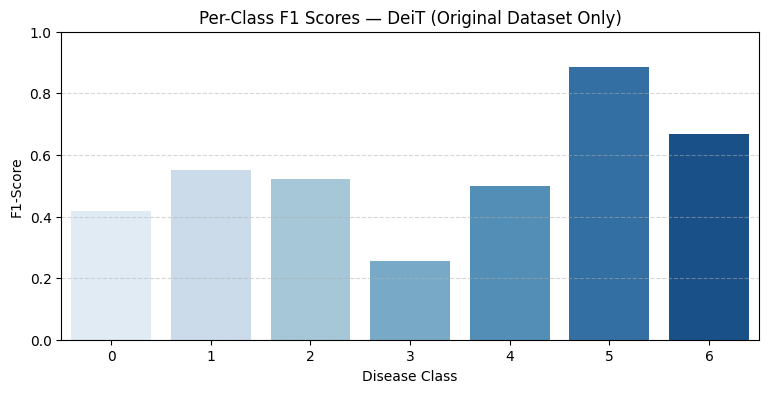

<Figure size 900x400 with 0 Axes>

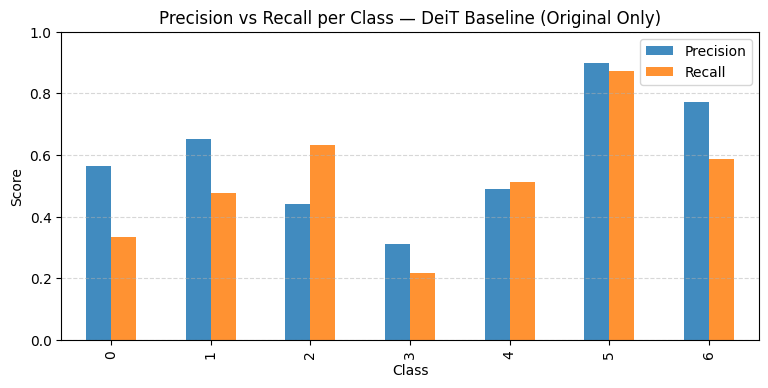

In [25]:
# ============================================
# PER-CLASS METRICS — DeiT Baseline (Original Only)
# ============================================

from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Generate detailed report
report_base = classification_report(y_true_base, y_pred_base, output_dict=True)

# Convert to DataFrame
df_base = pd.DataFrame(report_base).transpose().iloc[:n_classes, :].reset_index()
df_base.columns = ["Class", "Precision", "Recall", "F1-Score", "Support"]

print("\n📊 Per-Class Performance for DeiT (Original Data Only):")
display(df_base)

# --- Visualization: Per-Class F1 ---
plt.figure(figsize=(9,4))
sns.barplot(x="Class", y="F1-Score", data=df_base, palette="Blues")
plt.title("Per-Class F1 Scores — DeiT (Original Dataset Only)")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xlabel("Disease Class")
plt.ylabel("F1-Score")
plt.show()

# --- Optional: Precision vs Recall ---
plt.figure(figsize=(9,4))
df_base.set_index("Class")[["Precision", "Recall"]].plot(kind='bar', figsize=(9,4), alpha=0.85)
plt.title("Precision vs Recall per Class — DeiT Baseline (Original Only)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

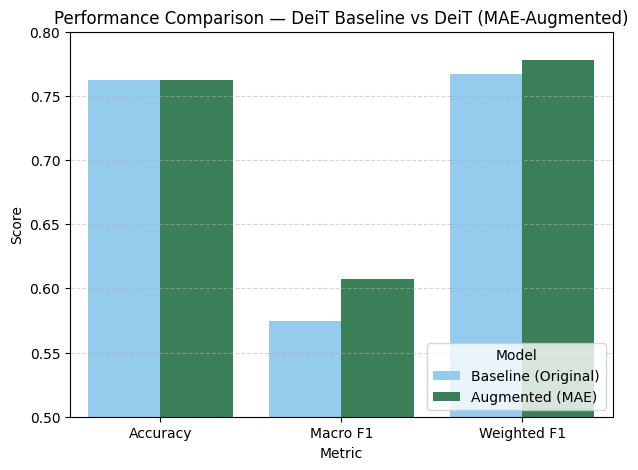

In [23]:
# ============================================
# COMPARISON: DeiT Baseline vs DeiT Augmented
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for plotting
comparison_df = pd.DataFrame({
    "Metric": ["Accuracy", "Macro F1", "Weighted F1"],
    "Baseline (Original)": [0.7621, 0.5749, 0.7669],   # from your results
    "Augmented (MAE)":     [0.7621, 0.6075, 0.7778]    # from your results
})

comparison_df_melted = comparison_df.melt(id_vars="Metric", var_name="Model", value_name="Score")

# Plot
plt.figure(figsize=(7,5))
sns.barplot(data=comparison_df_melted, x="Metric", y="Score", hue="Model", palette=["#87CEFA", "#2E8B57"])
plt.title("Performance Comparison — DeiT Baseline vs DeiT (MAE-Augmented)")
plt.ylim(0.5, 0.8)
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Model", loc="lower right")
plt.show()